In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import seaborn as sb
from src.core import *
from extcore import *
from plots import AAOCW, AAPGW
from src.lpf import *

In [4]:
sb.set_context('paper')
sb.set_style('white')

In [5]:
lpf = LPFRN()
fc = pd.read_hdf(result_file, 'ckrn_ldtk/fc')
mp = np.median(fc, 0)

## Plot the distributions

In [6]:
fcv = pd.read_hdf(result_file, 'vkrn_ldtk/fc')

In [7]:
lpfv = LPFRN(constant_k=False)

In [8]:
ks = sqrt(fcv.ix[:,4:11])
ks.columns=['k1 k2 k3 k4 k5 k6 k7'.split()]

In [9]:
sids = pd.Series(pd.Categorical(lpfv.unique_pbs, categories='g r i z J H K'.split())).sort(inplace=False).index.values

In [10]:
ki = ['k%i'%(i+1) for i in sids]

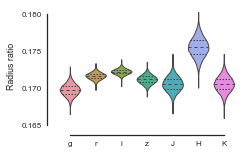

In [123]:
fig,ax = subplots(1,1, figsize=(AAOCW,0.65*AAOCW))
sb.violinplot(ks[ki], inner='quartile', scale='width', ax=ax, linewidth=1)
setp(ax, ylabel='Radius ratio', yticks=[0.165,0.17,0.175,0.18])
ax.set_xticklabels(passbands)
sb.despine(fig, offset=10, trim=True)
fig.tight_layout()
fig.savefig('plots/pub_ext_vk.pdf')

In [13]:
%run src/lpf.py

In [103]:
fcva = pd.read_hdf(result_file, 'vkrn/fc')
fcvb = pd.read_hdf(result_file, 'vkrn_ldtk/fc')

luva = array([map_ldc(fcva['q1_%i'%i].values, fcva['q2_%i'%i].values) for i in range(lpfv.npb)])
luvb = array([map_ldc(fcvb['q1_%i'%i].values, fcvb['q2_%i'%i].values) for i in range(lpfv.npb)])

In [120]:
passbands = lpf.cpassbands.cat.categories.values

In [121]:
dfua = pd.DataFrame(luva[sids,0,:].T, columns=passbands)
dfva = pd.DataFrame(luva[sids,1,:].T, columns=passbands)
dfub = pd.DataFrame(luvb[sids,0,:].T, columns=passbands)
dfvb = pd.DataFrame(luvb[sids,1,:].T, columns=passbands)

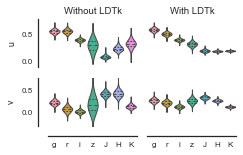

In [122]:
vpargs = dict(inner='quartile', orient='v', scale='width', linewidth=1)
fig, axs = subplots(2,2, figsize=(AAOCW,0.65*AAOCW), sharex=False)
sb.violinplot(dfua, ax=axs[0,0], **vpargs)
sb.violinplot(dfva, ax=axs[1,0], **vpargs)
sb.violinplot(dfub, ax=axs[0,1], **vpargs)
sb.violinplot(dfvb, ax=axs[1,1], **vpargs)
setp(axs[0,:], ylim=(-0.1,0.8))
setp(axs[1,:], ylim=(-0.3,0.8))
setp(axs[:,1], yticks=[])
setp(axs[0,0], ylabel='u')
setp(axs[1,0], ylabel='v')
axs[0,0].set_title('Without LDTk')
axs[0,1].set_title('With LDTk')
sb.despine(fig, offset=10)
sb.despine(ax=axs[0,0], left=False, bottom=True)
sb.despine(ax=axs[0,1], left=True, bottom=True)
sb.despine(ax=axs[1,1], left=True, bottom=False)
setp(axs[0,:], xticks=[])
fig.tight_layout()
fig.savefig('plots/pub_ext_ldcs.pdf')

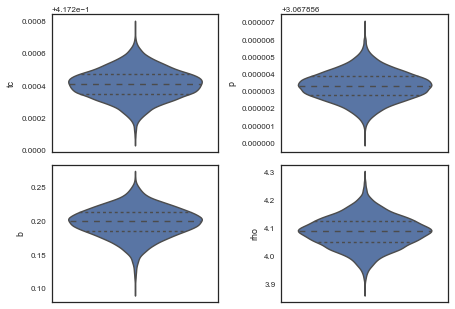

In [23]:
vpargs = dict(inner='quartile', orient='v', color=cp[2])
fig, axs = subplots(2,2)
sb.violinplot(fc.tc-fc.tc.min().round(), ax=axs[0,0], **vpargs)
sb.violinplot(fc.p, ax=axs[0,1], **vpargs)
sb.violinplot(fc.b, ax=axs[1,0], **vpargs)
sb.violinplot(fc.rho, ax=axs[1,1], **vpargs)
fig.tight_layout()

In [101]:
dff = pd.read_hdf('data/external_lcs.h5', 'transmission')

In [99]:
dff[dff<0.01] = nan

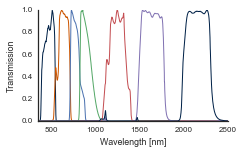

In [102]:
fig,ax = subplots(1,1,figsize=(AAOCW,0.65*AAOCW))
dff.plot(ax=ax, legend=False, lw=1)
setp(ax,  ylabel='Transmission', xlabel='Wavelength [nm]', ylim=(0,1))
sb.despine(fig, offset=0)
fig.tight_layout()
fig.savefig('plots/pub_ext_transmission.pdf')

In [11]:
lc_names = concatenate([lp.hps.lc_name.values for lp in lpf.lpfs])

In [12]:
lc_dsnames = [n.strip('/')[0].upper() for n in lc_names]

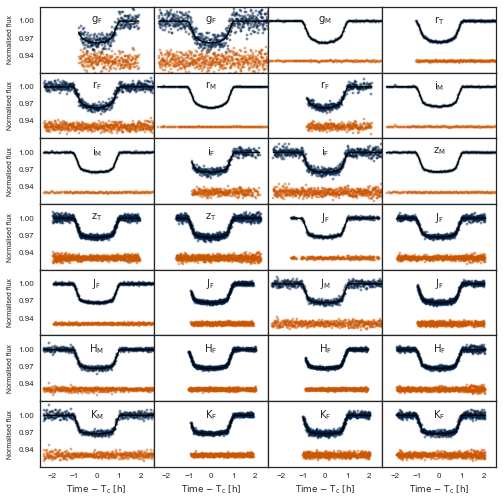

In [13]:
phases = [(fold(t, P, TC, 0.5) - 0.5)*24*P for t in lpf.times]
fluxes_m, residuals, gpmeans = [], [], []

for l in lpf.lpfs:
    fms = l.compute_lc_model(mp)
    res = [fo-fm for fo,fm in zip(l.fluxes, fms)]
    for i,gp in enumerate(l.gps):
        gp.flux = res[i]
        gpmeans.append(gp.predict(None))
    fluxes_m.extend(fms)
    residuals.extend(res)

fig,axs = pl.subplots(7,4, figsize=(AAPGW,AAPGW), sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    lcid = '{:s}$_\mathrm{{{:s}}}$'.format(lpf.passbands[ilc], lc_dsnames[ilc])
    a = axs.flat[iax]
    a.plot(phases[ilc],lpf.fluxes[ilc]-gpmeans[ilc],'.', alpha=0.5)
    a.plot(phases[ilc],fluxes_m[ilc],'k')
    a.plot(phases[ilc],lpf.fluxes[ilc]-fluxes_m[ilc]-gpmeans[ilc]+0.93,'.', alpha=0.5)
    a.text(0.5, 0.9, lcid, ha='center', va='top', size=10, transform=a.transAxes)
setp(axs, ylim=(0.91,1.025), xlim=(-0.035*24*P, 0.035*24*P))
setp(axs[-1,:], xlabel='Time - T$_c$ [h]', xticks=arange(-2,3))
setp(axs[0,0], ylabel='Normalised flux', yticks=[0.94,0.97,1.0])
[a.set_ylabel('Normalised flux', size=7) for a in axs[:,0]]
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('plots/pub_ext_modelled.pdf')

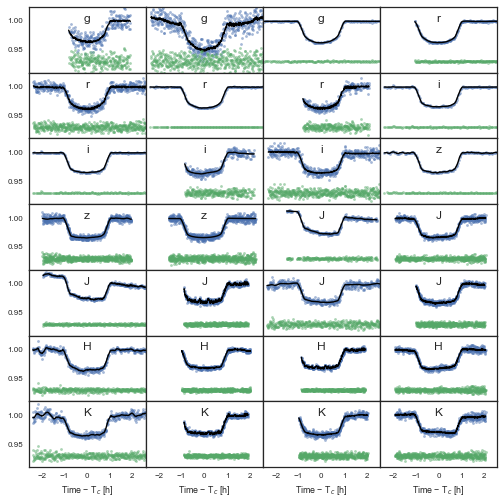

In [28]:
phases = [(fold(t, P, TC, 0.5) - 0.5)*24*P for t in lpf.times]
fluxes_m, residuals, gpmeans = [], [], []

for l in lpf.lpfs:
    fms = l.compute_lc_model(mp)
    res = [fo-fm for fo,fm in zip(l.fluxes, fms)]
    for i,gp in enumerate(l.gps):
        gp.flux = res[i]
        gpmeans.append(gp.predict(None))
    fluxes_m.extend(fms)
    residuals.extend(res)

fig,axs = pl.subplots(7,4, figsize=(AAPGW,AAPGW), sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    a = axs.flat[iax]
    a.plot(phases[ilc],lpf.fluxes[ilc],'.', alpha=0.5)
    a.plot(phases[ilc],fluxes_m[ilc]+gpmeans[ilc],'k')
    a.plot(phases[ilc],lpf.fluxes[ilc]-fluxes_m[ilc]-gpmeans[ilc]+0.93,'.', alpha=0.5)
    a.text(0.5, 0.9, lpf.passbands[ilc], ha='center', va='top', size=12, transform=a.transAxes)
pl.setp(axs, ylim=(0.91,1.025), xlim=(-0.035*24*P, 0.035*24*P))
pl.setp(axs[-1,:], xlabel='Time - T$_c$ [h]', xticks=arange(-2,3))
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)